## Author: Gerardo Salazar

I believe that investor sentiment on a few given days where volatility is exceptionally high is skewed and they are more likely to make the wrong predictions. We will start out by importing sentiment data and normalizing it against `SPY`.

In [26]:
from __future__ import print_function

from quantopian.interactive.data.psychsignal import stocktwits
from quantopian.pipeline.data.psychsignal import stocktwits as stocktwats_pl
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.pipeline.filters import Q1500US
from quantopian.pipeline.experimental import QTradableStocksUS
from quantopian.research.experimental import continuous_future
from quantopian.research import run_pipeline

from odo import odo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy
import pykalman
import alphalens

In [3]:
starting_date = '2010-01-01'
#thirty_days = '2017-02-10'
thirty_days = '2010-01-10'
ending_date = '2016-01-01'

In [6]:
sentiment_data = odo(stocktwits, pd.DataFrame)
#sentiment_data.set_index('timestamp').sort_index(inplace=True)

In [7]:
# Get S&P500 E-Mini futures
ES = get_pricing(continuous_future('ES'), fields=['close_price', 'volume'], start_date=starting_date, end_date=ending_date)
SPY = get_pricing('SPY', fields=['close_price', 'volume'], start_date=starting_date, end_date=ending_date)
QQQ = get_pricing('QQQ', fields=['close_price', 'volume'], start_date=starting_date, end_date=ending_date)

In [8]:
def get_symbol_sentiment(symbol, start_date=starting_date, end_date=ending_date):
    return odo(stocktwits[stocktwits.symbol == symbol], pd.DataFrame).set_index('timestamp').sort_index().loc[start_date:end_date]

In [9]:
SPY_sentiment = get_symbol_sentiment('SPY')
QQQ_sentiment = get_symbol_sentiment('QQQ')

Let's normalize all of our sentiment data so that we can work more easily with it. We will apply a Kalman Filter to the message volume data to extract clean results from the extreme variance in the value. Optionally, we can smoothen the data, but we choose not to.

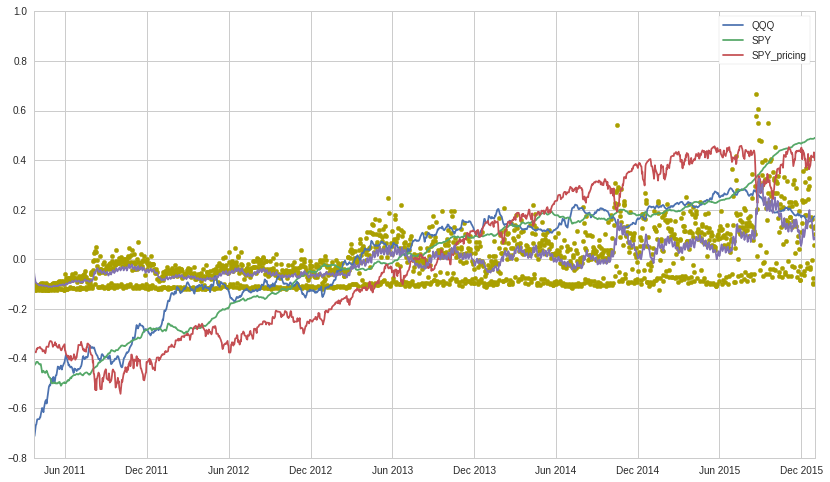

In [10]:
sentiment_normalized = pd.DataFrame()
sentiment_normalized['QQQ'] = QQQ_sentiment['bull_minus_bear'].replace(0, np.nan).fillna(method='ffill').cumsum()
sentiment_normalized['SPY'] = SPY_sentiment['bull_minus_bear'].replace(0, np.nan).fillna(method='ffill').cumsum()
sentiment_normalized.index = [idx_entry.date() for idx_entry in sentiment_normalized.index]
sentiment_normalized = sentiment_normalized.iloc[1:]

SPY_cpy = SPY.copy()
SPY_cpy.index = [idx_entry.date() for idx_entry in SPY_cpy.index]
sentiment_normalized['SPY_pricing'] = SPY_cpy['close_price']
sentiment_normalized.fillna(method='ffill')
#sentiment_normalized.div(sentiment_normalized.iloc[0]).plot()
sentiment_normalized = (sentiment_normalized - sentiment_normalized.mean()) / (sentiment_normalized.max() - sentiment_normalized.min())
sentiment_normalized['SPY'] = sentiment_normalized['SPY'].mul(-1)
sentiment_normalized.dropna().plot()

SPY_msgs = SPY_sentiment.copy()['total_scanned_messages'].to_frame().loc[sentiment_normalized.index[0]:]
SPY_msgs = (SPY_msgs - SPY_msgs.mean()) / (SPY_msgs.max() - SPY_msgs.min())
SPY_msgs.index = [idx_entry.date() for idx_entry in SPY_msgs.index]
plt.scatter(SPY_msgs.index, SPY_msgs['total_scanned_messages'], color='#aaa000')

# Kalman Filter Estimate
kf = pykalman.KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

msg_volume_state_estimate, _ = kf.filter(SPY_msgs.values)#kf.smooth(kf.filter(SPY_msgs.values)[0])
# Depending if we want to smoothen our data out, we can apply the kf.smooth function to the now filtered values.
SPY_msgs['kalman_msgvol_estimate'] = msg_volume_state_estimate
SPY_msgs['kalman_msgvol_estimate'].loc[sentiment_normalized.index[0]:].plot()


In [27]:
# Let's create a Pipeline and such so that we can analyze our data using alphalens
ITERATIONS = 0

# Create Kalman filter for smoothening message volume data
KF = pykalman.KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

class SentimentVolumeKalman(CustomFactor):
    def compute(self, today, assets, out, *inputs):
        global ITERATIONS
        global KF
        
        ITERATIONS += 1
        
        if ITERATIONS % 100 == 0:
            print(ITERATIONS)
        
        # Transpose the inputs so that we can loop over them with ease.
        us_equities = inputs[0].T
        bb_ratio = inputs[2].T
        
        # Create empty list that will contain our factors here
        w_bb = np.empty(inputs[1].shape[1])
        
        # loop over our values so that we can pass in clean inputs to the kalman filter and 
        # scipy's linear regression function.
        for security_index, equity_sent_vol in enumerate(inputs[1].T):
            # Estimate data. Optionally, you can choose to smoothen the data using the kf.smooth() function.
            # kf.filter returns an array with lists as their entries. Flatten the array.
            smooth_vol = np.asarray([value for entry in KF.smooth(KF.filter(equity_sent_vol)[0])[0] for value in entry])
            
            # Normalize the estimated data
            smooth_vol_norm = (smooth_vol - smooth_vol.min()) / (smooth_vol.max() - smooth_vol.min())
            
            # Normalize our price data so that we can use it for linear regression analysis.
            current_eq = us_equities[security_index]
            current_eq_min = current_eq.min()
            current_eq_max = current_eq.max()
            
            norm_eq = (current_eq - current_eq_min) / (current_eq_max - current_eq_min)

            # Create weighted bull/bear ratio and apply a R^2 bias to it.
            w_bb[security_index] = ((bb_ratio[security_index] * smooth_vol_norm) + (
                scipy.stats.linregress(norm_eq, smooth_vol_norm)[2] ** 2
            ))[-1]
        
        # Finally, transpose the w_bb back to its intended form
        out[:] = np.array(w_bb).T

In [28]:
class MsgVolKalman(CustomFactor):
    def compute(self, today, assets, out, *inputs):
        pass

In [5]:
def make_sentiment_msgvol_pipeline():
    sentiment_factor = SentimentVolumeKalman(inputs = [
        USEquityPricing.close, 
        stocktwats_pl.total_scanned_messages, 
        stocktwats_pl.bull_bear_msg_ratio
    ], window_length=10, mask=QTradableStocksUS())
    
    return Pipeline(
        columns={
            'msgvol_kalman': sentiment_factor
        }
    )

In [13]:
ITERATIONS = 0

pl = run_pipeline(make_sentiment_msgvol_pipeline(), start_date='2015-01-01', end_date='2016-01-01')

100
200


In [10]:
pl2 = run_pipeline(make_sentiment_msgvol_pipeline(), start_date='2016-01-01', end_date='2017-01-01')

100
200


In [12]:
#stock_list = pl.index.levels[1].unique()
stock_listpl2 = pl2.index.levels[1].unique()

In [13]:
stock_prices = get_pricing(
    stock_listpl2, 
    frequency='daily', 
    fields='open_price', 
    start_date=pl2.index.levels[0][0],
    end_date=pl2.index.levels[0][-1]
)

In [16]:
factor_fw = alphalens.utils.get_clean_factor_and_forward_returns(
    pl2.mul(-1),
    stock_prices,
    quantiles=5,
    periods=(1,2,3,4,5)
)

Quantiles Statistics


min        max      mean       std  count    count %
factor_quantile                                                               
1                9.456024e-13   0.150006  0.021895  0.021533  97391  20.021462
2                2.917866e-02   0.442570  0.141684  0.062333  97233  19.988981
3                1.275727e-01   0.667624  0.339901  0.091198  97241  19.990626
4                3.004285e-01   0.889056  0.583258  0.103231  97233  19.988981
5                5.582655e-01  39.904755  1.657611  1.687612  97335  20.009950

Returns Analysis


1      2      3      4  \
Ann. alpha                                     0.015 -0.008 -0.009 -0.013   
beta                                           0.099  0.101  0.112  0.107   
Mean Period Wise Return Top Quantile (bps)    -0.652 -1.541 -2.648 -2.648   
Mean Period Wise Return Bottom Quantile (bps)  1.085  2.032  1.979  2.380   
Mean Period Wise Spread (bps)                 -1.692 -1.767 -1.516 -1.234   

                                                   5  
Ann. alpha                                    -0.014  
beta                                           0.087  
Mean Period Wise Return Top Quantile (bps)    -3.563  
Mean Period Wise Return Bottom Quantile (bps)  2.912  
Mean Period Wise Spread (bps)                 -1.273

/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=2).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=2).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=3).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plo

Information Analysis


1      2      3      4      5
IC Mean     -0.002 -0.004 -0.004 -0.004 -0.005
IC Std.      0.048  0.049  0.049  0.048  0.047
t-stat(IC)  -0.629 -1.190 -1.351 -1.430 -1.554
p-value(IC)  0.530  0.235  0.178  0.154  0.121
IC Skew      0.113  0.338  0.305  0.263  0.280
IC Kurtosis  0.773  0.292  0.614  0.591  0.394
Ann. IR     -0.634 -1.199 -1.361 -1.442 -1.567

Turnover Analysis


1      2      3      4      5
Quantile 1 Mean Turnover   0.562  0.698  0.752  0.776  0.787
Quantile 2 Mean Turnover   0.686  0.749  0.771  0.787  0.791
Quantile 3 Mean Turnover   0.678  0.770  0.789  0.794  0.797
Quantile 4 Mean Turnover   0.580  0.718  0.771  0.792  0.799
Quantile 5 Mean Turnover   0.415  0.524  0.596  0.644  0.669

1      2      3      4      5
Mean Factor Rank Autocorrelation  0.582  0.378  0.246  0.163  0.119

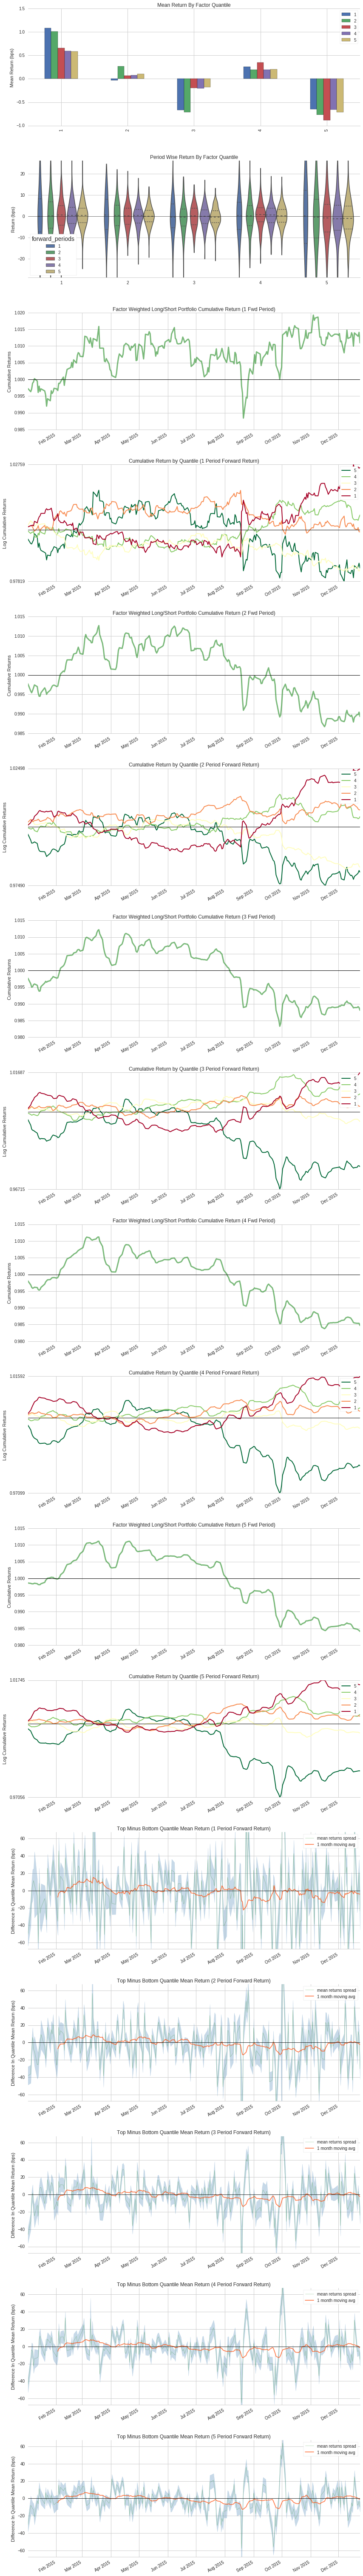

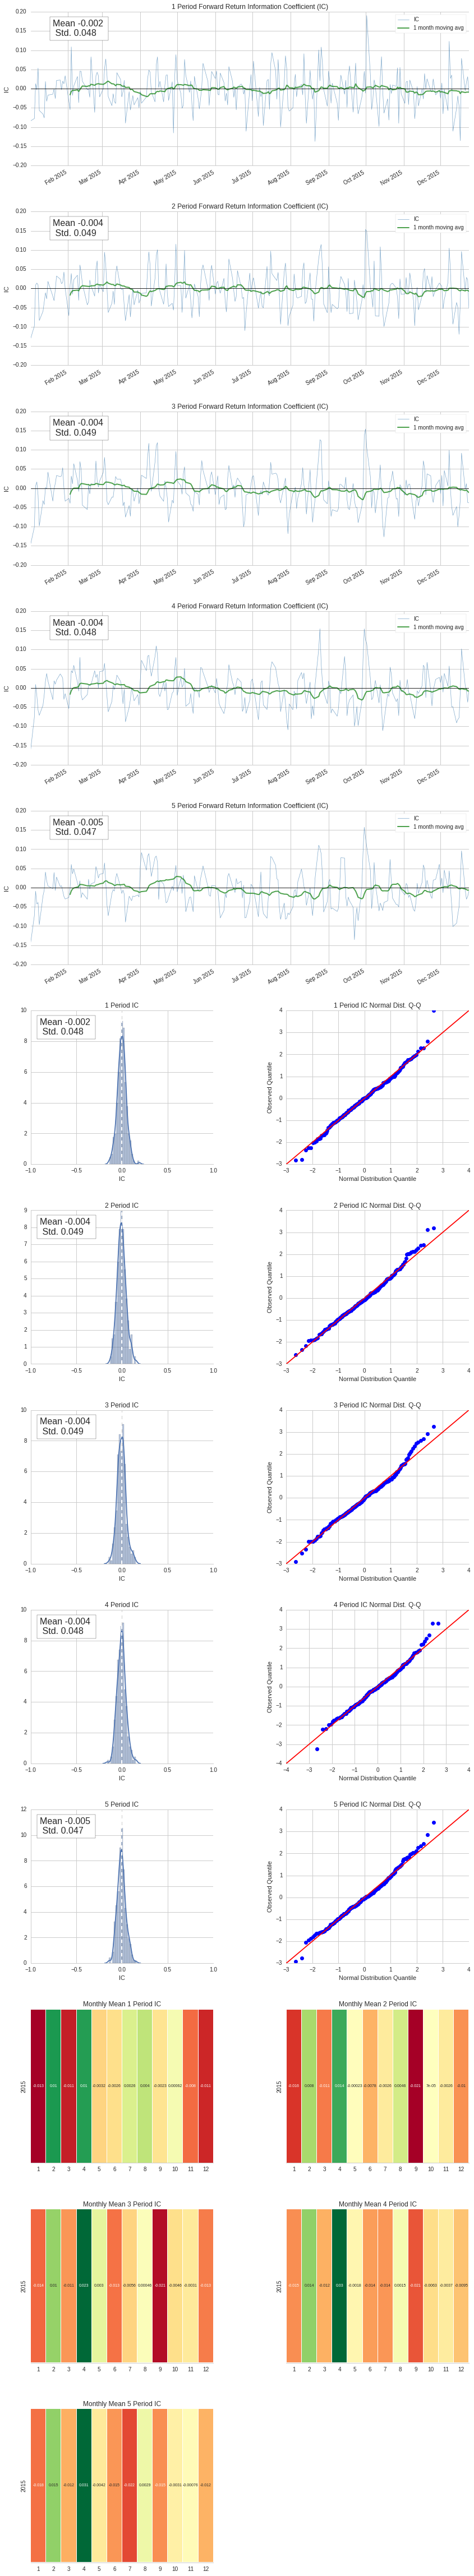

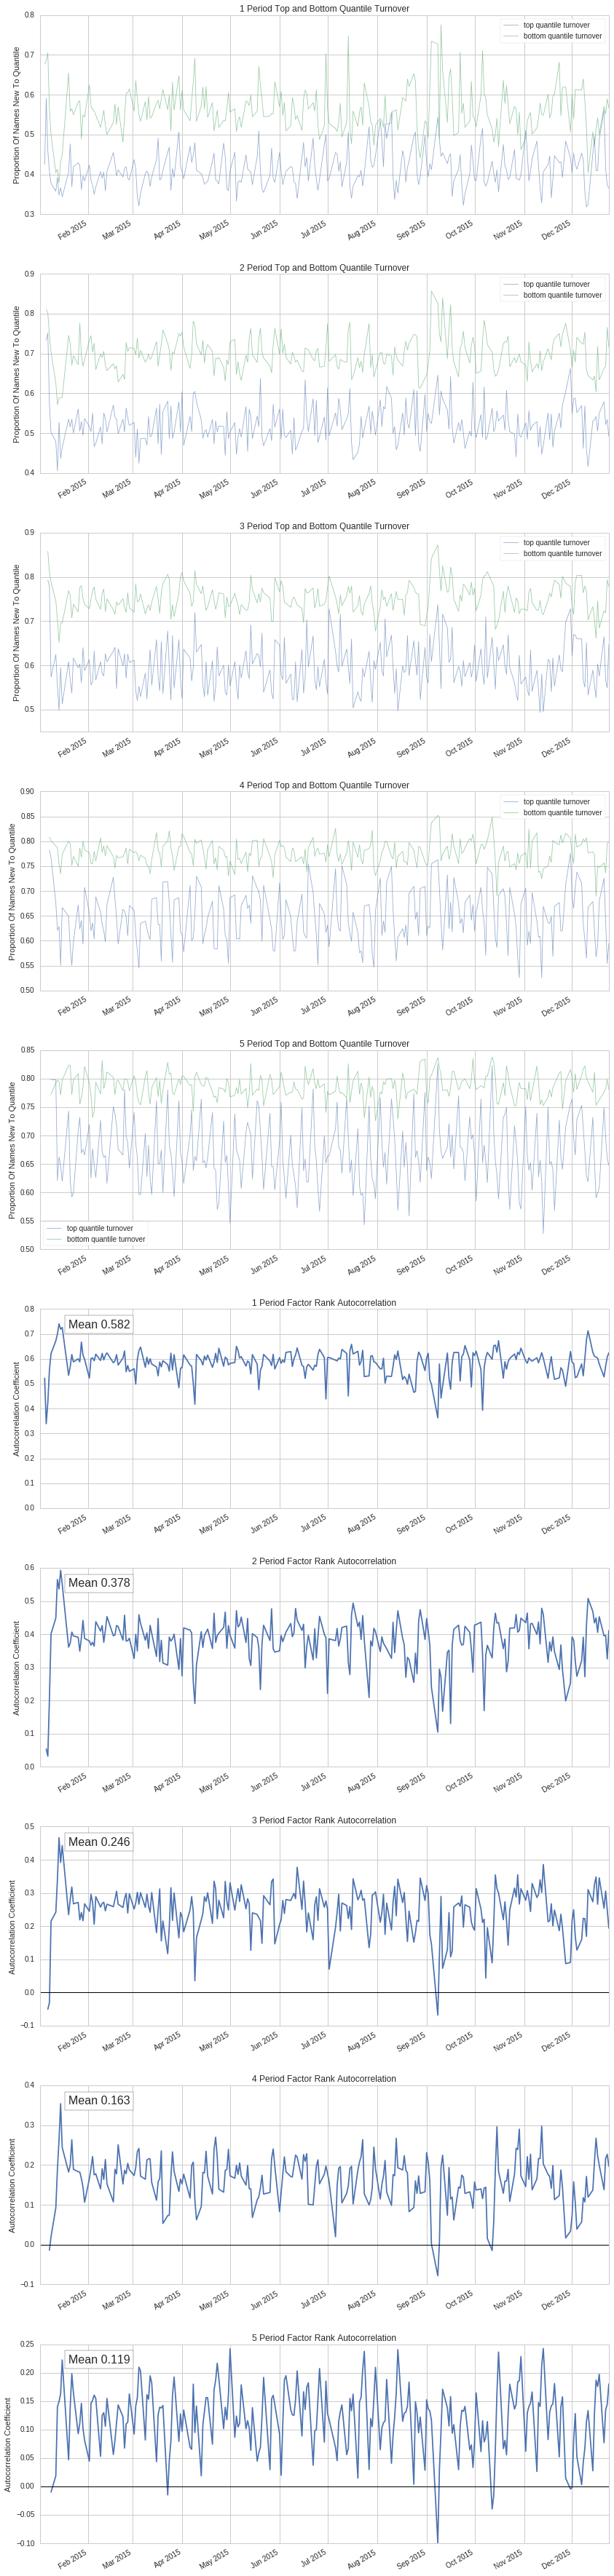

In [37]:
# The output of this data is for the 2015-2016 period.
alphalens.tears.create_full_tear_sheet(factor_fw, long_short=True)

Quantiles Statistics


min           max      mean       std  count    count %
factor_quantile                                                               
1               -31.160624 -6.012553e-01 -1.962064  1.775627  98104  20.018528
2                -1.060617 -2.861243e-01 -0.734705  0.114557  97971  19.991389
3                -0.904499 -1.239977e-01 -0.517512  0.145356  97961  19.989348
4                -0.816880 -2.960390e-02 -0.274426  0.141077  97971  19.991389
5                -0.555561 -7.020990e-13 -0.055720  0.068656  98059  20.009346

Returns Analysis


1      2      3      4  \
Ann. alpha                                     0.051  0.042  0.044  0.044   
beta                                          -0.090 -0.059 -0.034 -0.045   
Mean Period Wise Return Top Quantile (bps)     0.560  0.357  0.792  1.219   
Mean Period Wise Return Bottom Quantile (bps) -1.487 -2.824 -4.480 -6.371   
Mean Period Wise Spread (bps)                  2.022  1.582  1.758  1.899   

                                                   5  
Ann. alpha                                     0.045  
beta                                          -0.045  
Mean Period Wise Return Top Quantile (bps)     1.379  
Mean Period Wise Return Bottom Quantile (bps) -8.144  
Mean Period Wise Spread (bps)                  1.909

Information Analysis


1      2      3      4      5
IC Mean      0.006  0.007  0.009  0.010  0.010
IC Std.      0.067  0.070  0.065  0.065  0.066
t-stat(IC)   1.381  1.634  2.148  2.456  2.448
p-value(IC)  0.168  0.104  0.033  0.015  0.015
IC Skew      0.895  0.900  0.704  0.725  0.547
IC Kurtosis  2.153  2.276  2.223  2.142  1.145
Ann. IR      1.392  1.647  2.166  2.475  2.468

Turnover Analysis


1      2      3      4      5
Quantile 1 Mean Turnover   0.436  0.534  0.588  0.623  0.636
Quantile 2 Mean Turnover   0.533  0.683  0.756  0.790  0.799
Quantile 3 Mean Turnover   0.638  0.767  0.792  0.792  0.791
Quantile 4 Mean Turnover   0.662  0.737  0.763  0.781  0.790
Quantile 5 Mean Turnover   0.502  0.680  0.752  0.780  0.790

1     2      3      4      5
Mean Factor Rank Autocorrelation  0.618  0.41  0.257  0.166  0.127

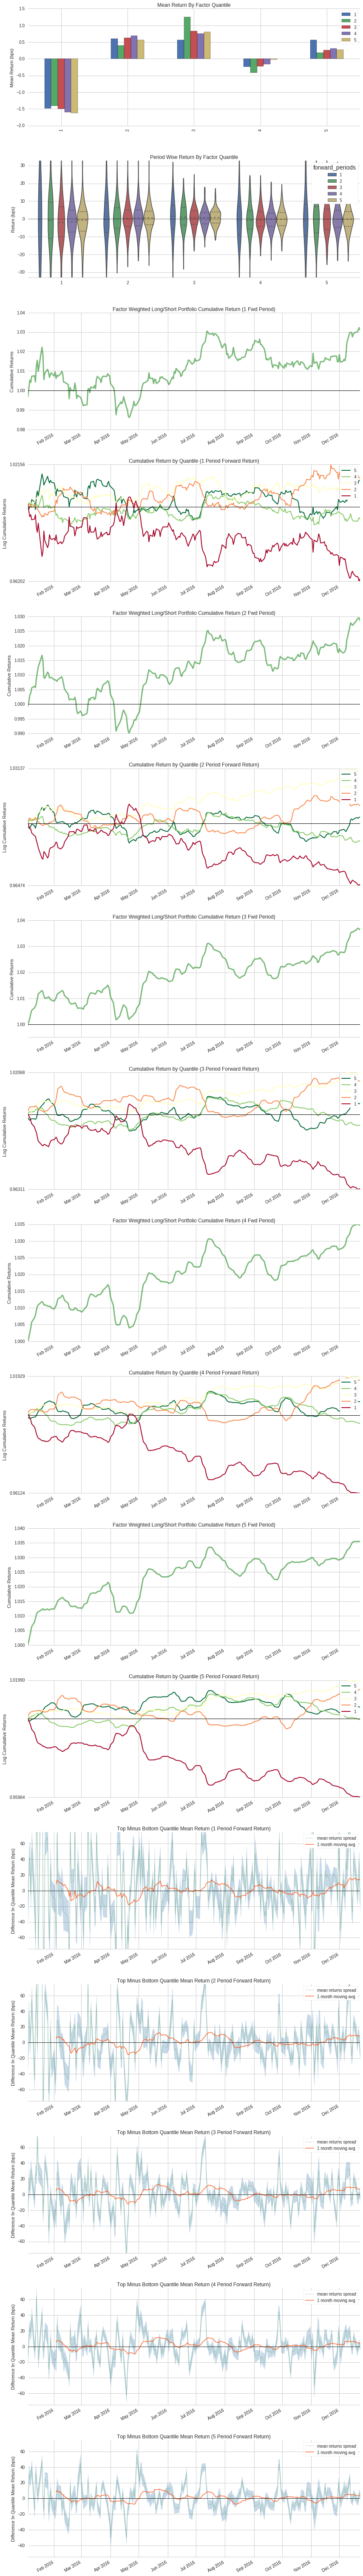

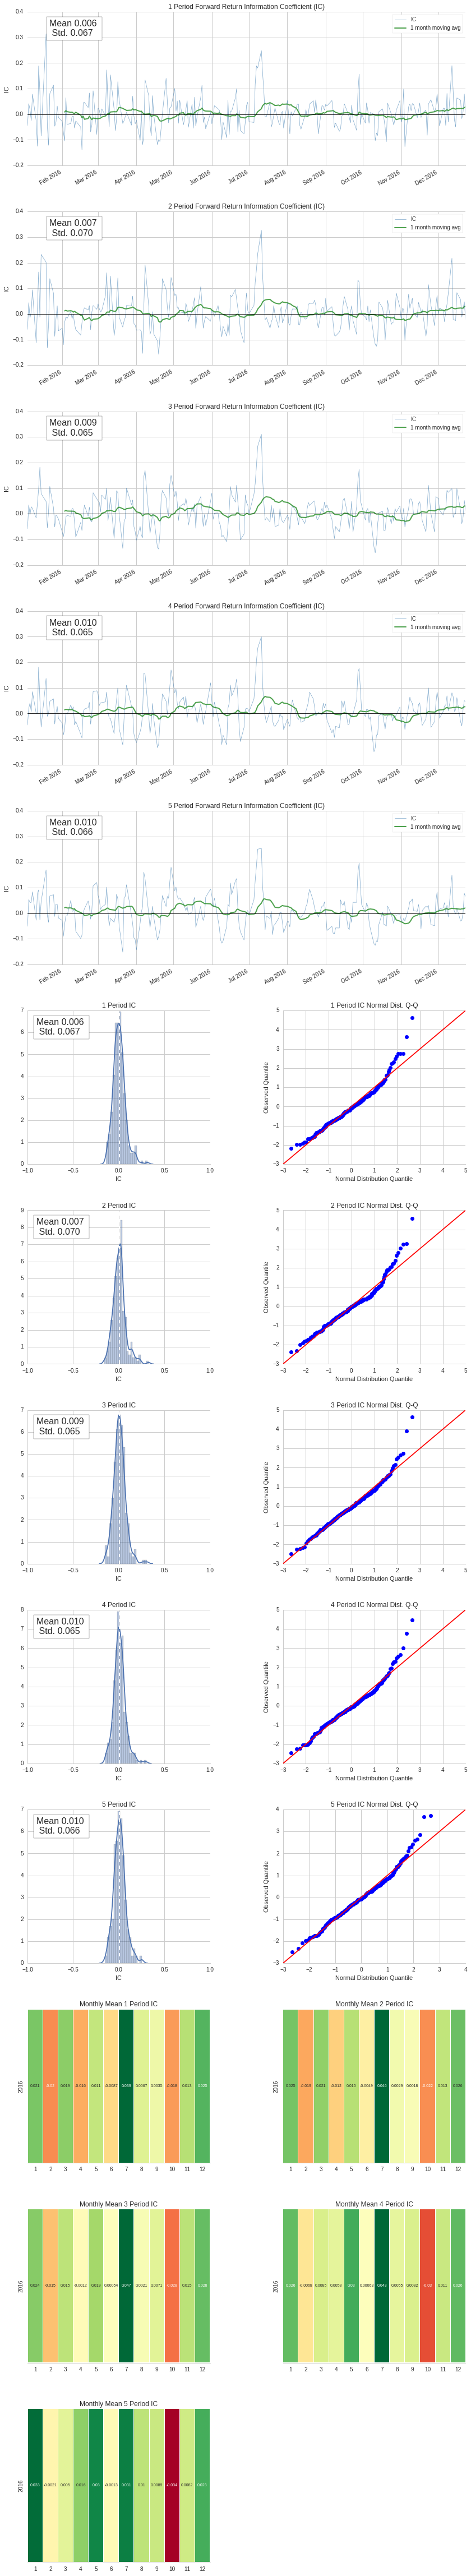

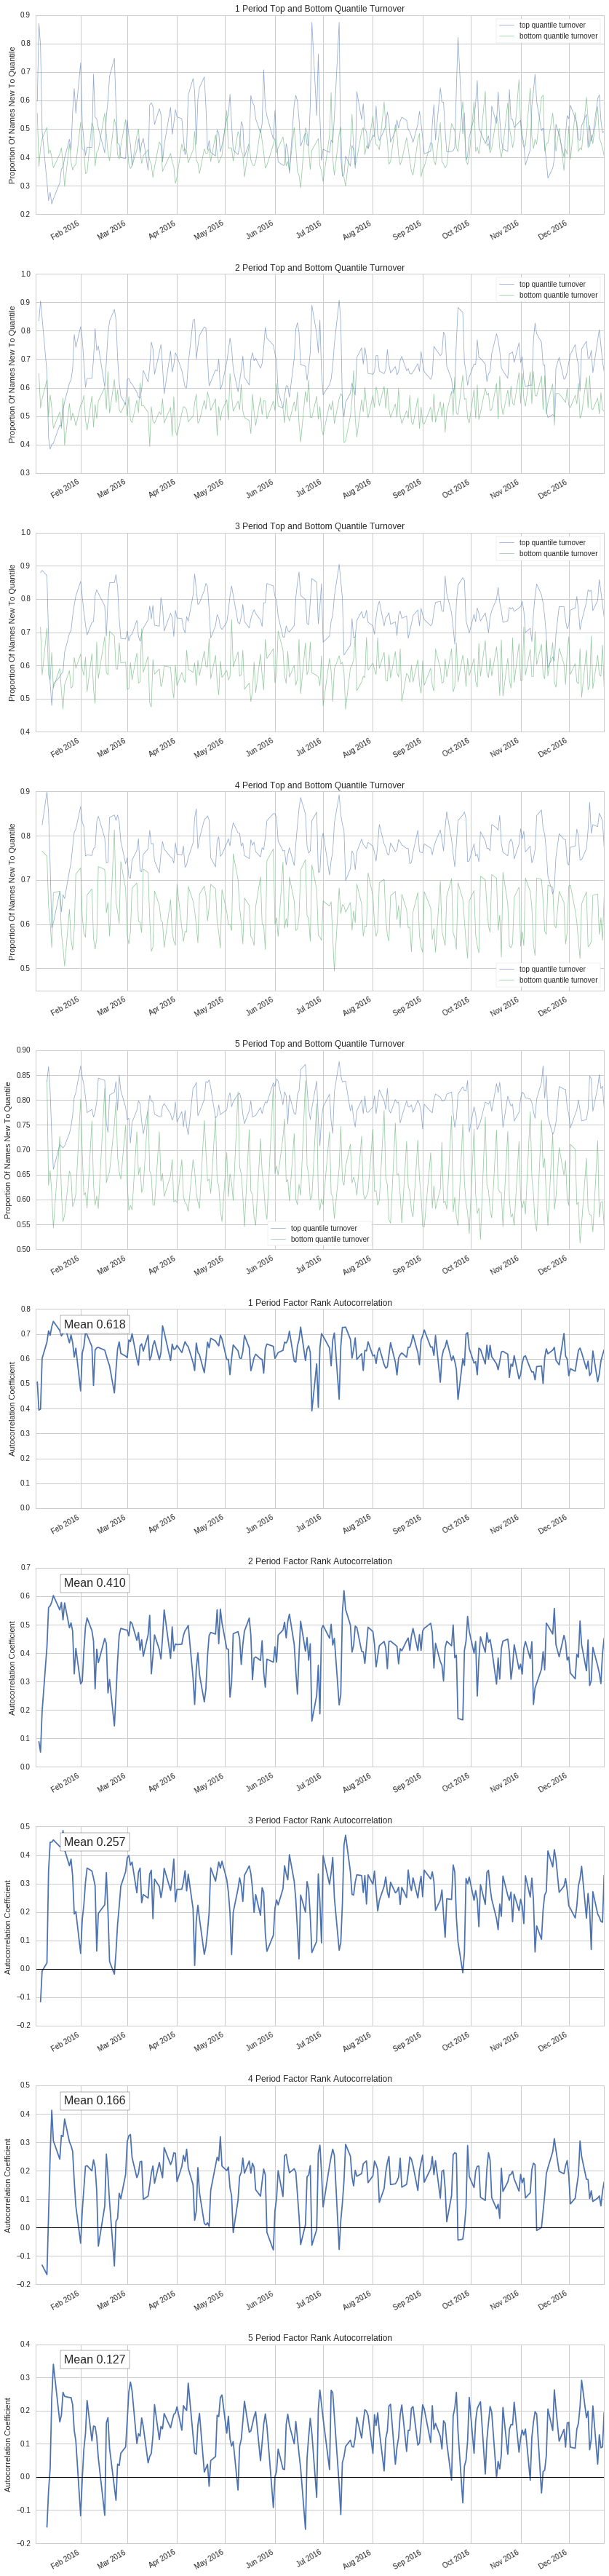

In [17]:
alphalens.tears.create_full_tear_sheet(factor_fw, long_short=True)

In [19]:
sent_pl = run_pipeline(sentiment_pipeline(), start_date='2015-01-01', end_date='2016-01-01')

NameError: name 'sentiment_pipeline' is not defined

In [18]:
sent_ffw = alphalens.utils.get_clean_factor_and_forward_returns(
    sent_pl,
    stock_prices,
    quantiles=None,
    bins=[0,1,5,100,1000,1e5,1e6,1e7],
    periods=(1,2,3,4,5)
)

NameError: name 'sent_pl' is not defined

Quantiles Statistics


min   max      mean       std  count    count %
factor_quantile                                                  
1.0              0.06   1.0  0.840847  0.243850  23884  41.107726
2.0              1.01   5.0  2.516041  1.023740  30149  51.890673
3.0              5.07  39.0  8.074159  3.118765   4068   7.001601

Returns Analysis


1
Ann. alpha                                     0.068
beta                                          -0.015
Mean Period Wise Return Top Quantile (bps)     7.331
Mean Period Wise Return Bottom Quantile (bps)  2.002
Mean Period Wise Spread (bps)                  7.712

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Information Analysis


1
IC Mean     -0.003
IC Std.      0.088
t-stat(IC)  -0.514
p-value(IC)  0.608
IC Skew     -0.113
IC Kurtosis  0.033
Ann. IR     -0.514

Turnover Analysis


1
Quantile 1 Mean Turnover   0.772
Quantile 2 Mean Turnover   0.584
Quantile 3 Mean Turnover   0.840

1
Mean Factor Rank Autocorrelation  0.256

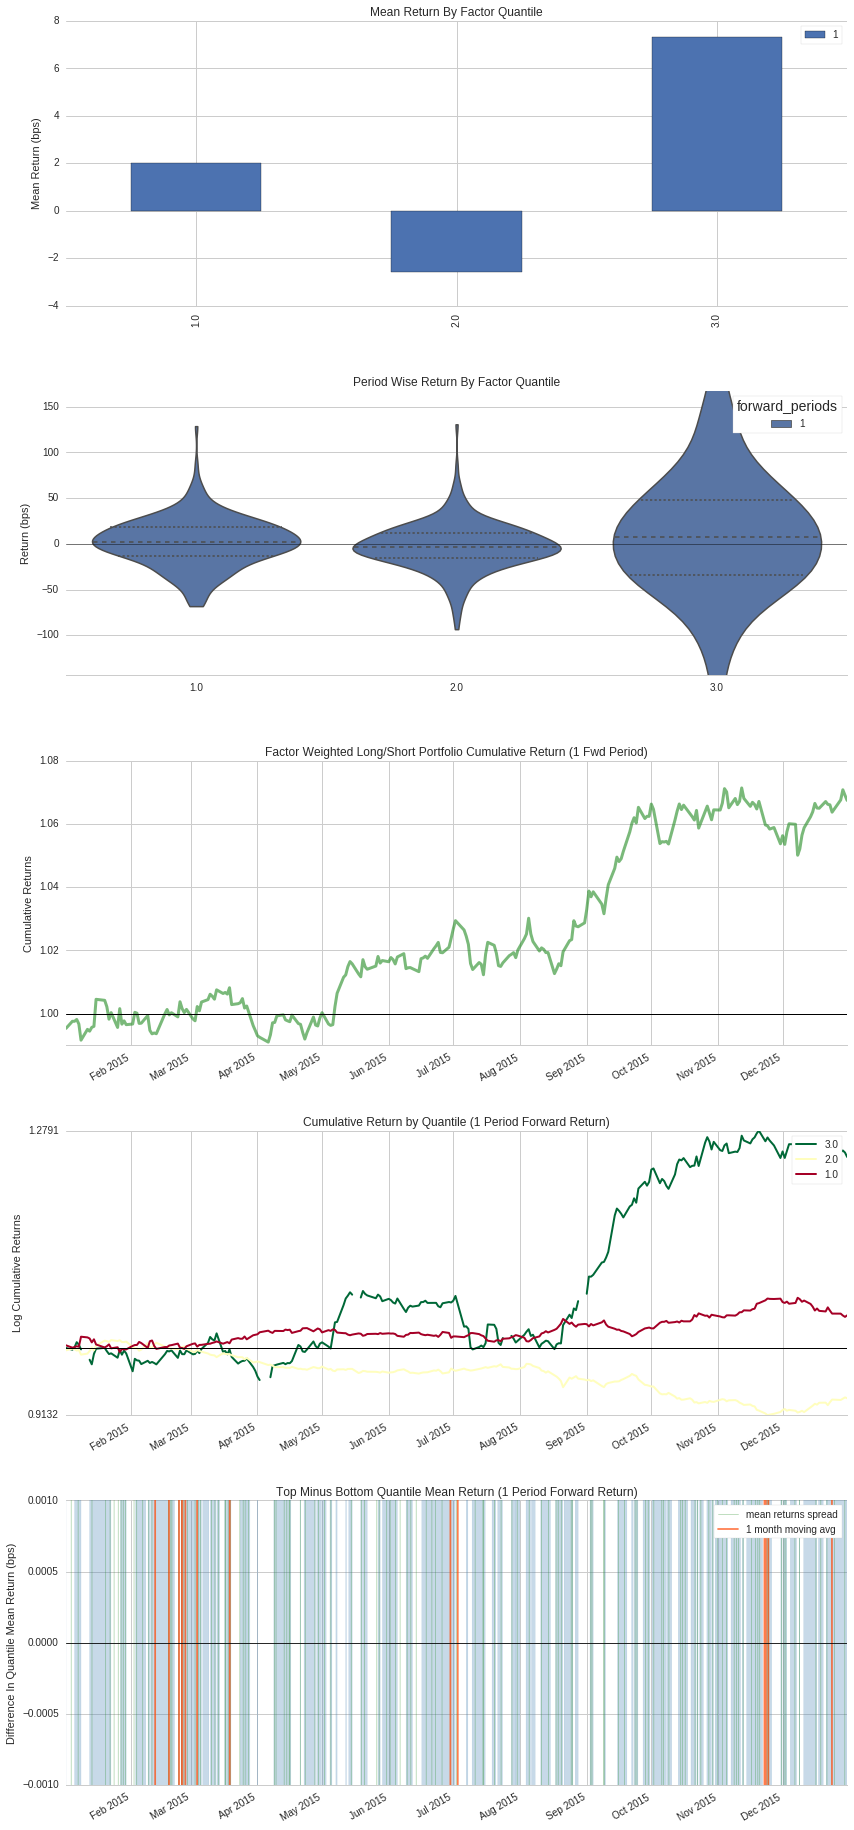

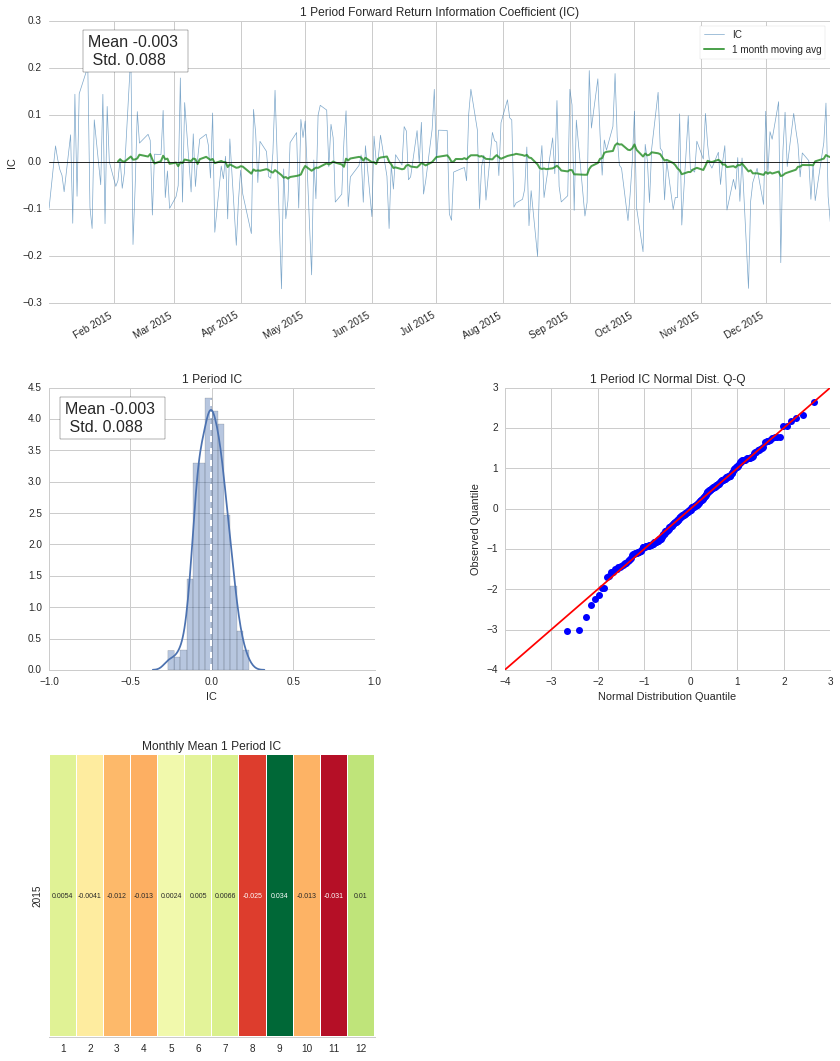

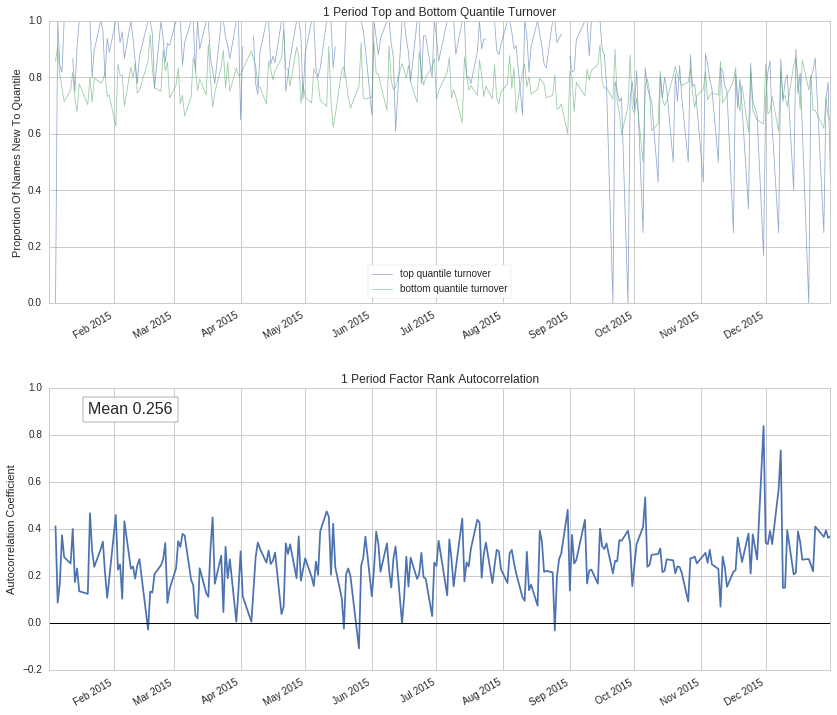

In [35]:
alphalens.tears.create_full_tear_sheet(sent_ffw)

In [25]:
pl2[(pl2.dropna() < 0)].dropna()

Empty DataFrame
Columns: [msgvol_kalman]
Index: []